In [1]:
from neural_network import NeuralNetwork
from data import Instance, DataSet
from miscellaneous import initialize_data, plot_graph, plot_points
from activation_function import *
import matplotlib.pyplot as plt
import pandas as pd
import copy
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings
import itertools
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Carregando dados e Ajustando labels

In [3]:
# Carregando dados
train = pd.read_csv('../dataset/train.csv')
test = pd.read_csv('../dataset/test.csv')

# Ajustando nomes
train_labels = [i.lower() for i in train.columns.values]
test_labels = [i.lower() for i in test.columns.values]

rename_dict_train = { i: j for i,j in zip(train.columns.values, train_labels) }
rename_dict_test = { i: j for i,j in zip(test.columns.values, test_labels) }

train.rename(columns = rename_dict_train, inplace = True)
test.rename(columns = rename_dict_test, inplace = True)

#### Selecionando atributos relevantes

In [4]:
train = train.filter(['pclass', 'sex', 'age', 'fare', 'cabin', 'embarked', 'survived'], axis = 1)
test = test.filter(['pclass', 'sex', 'age', 'fare', 'cabin', 'embarked', 'survived'], axis = 1)
display(train[0:10])

,pclass,sex,age,fare,cabin,embarked,survived
0,3,male,22.0,7.2500,NaN,S,0
1,1,female,38.0,71.2833,C85,C,1
2,3,female,26.0,7.9250,NaN,S,1
3,1,female,35.0,53.1000,C123,S,1
4,3,male,35.0,8.0500,NaN,S,0
5,3,male,NaN,8.4583,NaN,Q,0
6,1,male,54.0,51.8625,E46,S,0
7,3,male,2.0,21.0750,NaN,S,0
8,3,female,27.0,11.1333,NaN,S,1
9,2,female,14.0,30.0708,NaN,C,1


##### Fare e Age - Completando valores ausentes

In [5]:
#train['age'].fillna(train['age'].median(), inplace = True)
#test['age'].fillna(test['age'].median(), inplace = True)

train.dropna(subset = ['age'], inplace = True)
test.dropna(subset = ['age'], inplace = True)

train['fare'].fillna(train['fare'].median(), inplace = True)
test['fare'].fillna(test['fare'].median(), inplace = True)

display(train[0:10])

,pclass,sex,age,fare,cabin,embarked,survived
0,3,male,22.0,7.2500,NaN,S,0
1,1,female,38.0,71.2833,C85,C,1
2,3,female,26.0,7.9250,NaN,S,1
3,1,female,35.0,53.1000,C123,S,1
4,3,male,35.0,8.0500,NaN,S,0
6,1,male,54.0,51.8625,E46,S,0
7,3,male,2.0,21.0750,NaN,S,0
8,3,female,27.0,11.1333,NaN,S,1
9,2,female,14.0,30.0708,NaN,C,1
10,3,female,4.0,16.7000,G6,S,1


##### Sex - Transformando em atributo numérico

In [6]:
binarizer = LabelBinarizer()
train['sex'] = binarizer.fit_transform(train['sex'])
test['sex'] = binarizer.fit_transform(test['sex'])

display(train[0:10])

,pclass,sex,age,fare,cabin,embarked,survived
0,3,1,22.0,7.2500,NaN,S,0
1,1,0,38.0,71.2833,C85,C,1
2,3,0,26.0,7.9250,NaN,S,1
3,1,0,35.0,53.1000,C123,S,1
4,3,1,35.0,8.0500,NaN,S,0
6,1,1,54.0,51.8625,E46,S,0
7,3,1,2.0,21.0750,NaN,S,0
8,3,0,27.0,11.1333,NaN,S,1
9,2,0,14.0,30.0708,NaN,C,1
10,3,0,4.0,16.7000,G6,S,1


##### Embarked - Completando valores ausentes e Transformando em atributo numérico

In [7]:
train['embarked'].fillna(str(train['embarked'].mode()), inplace = True)
test['embarked'].fillna(str(test['embarked'].mode()), inplace = True)

encoder = LabelEncoder()
train['embarked'] = encoder.fit_transform(train['embarked'])
test['embarked'] = encoder.fit_transform(test['embarked'])

display(train[0:10])

,pclass,sex,age,fare,cabin,embarked,survived
0,3,1,22.0,7.2500,NaN,3,0
1,1,0,38.0,71.2833,C85,1,1
2,3,0,26.0,7.9250,NaN,3,1
3,1,0,35.0,53.1000,C123,3,1
4,3,1,35.0,8.0500,NaN,3,0
6,1,1,54.0,51.8625,E46,3,0
7,3,1,2.0,21.0750,NaN,3,0
8,3,0,27.0,11.1333,NaN,3,1
9,2,0,14.0,30.0708,NaN,1,1
10,3,0,4.0,16.7000,G6,3,1


##### Cabin - Transformando em atributo numérico

In [8]:
train.loc[train['cabin'].notnull(), 'cabin'] = train['cabin'].str[0]
test.loc[test['cabin'].notnull(), 'cabin'] = test['cabin'].str[0]

train['cabin'].fillna('H', inplace = True)
test['cabin'].fillna('H', inplace = True)

train['cabin'] = encoder.fit_transform(train['cabin'])
test['cabin'] = encoder.fit_transform(test['cabin'])

display(train)

,pclass,sex,age,fare,cabin,embarked,survived
0,3,1,22.0,7.2500,7,3,0
1,1,0,38.0,71.2833,2,1,1
2,3,0,26.0,7.9250,7,3,1
3,1,0,35.0,53.1000,2,3,1
4,3,1,35.0,8.0500,7,3,0
6,1,1,54.0,51.8625,4,3,0
7,3,1,2.0,21.0750,7,3,0
8,3,0,27.0,11.1333,7,3,1
9,2,0,14.0,30.0708,7,1,1
10,3,0,4.0,16.7000,6,3,1


##### Remoção de Outliers

In [9]:
for c1, c2 in zip(train, test):
    train = train[~(np.abs(train[c1]-train[c1].mean())>(3*train[c1].std()))]
    test = test[~(np.abs(test[c2]-test[c2].mean())>(3*test[c2].std()))]
    
display(train)

,pclass,sex,age,fare,cabin,embarked,survived
0,3,1,22.0,7.2500,7,3,0
1,1,0,38.0,71.2833,2,1,1
2,3,0,26.0,7.9250,7,3,1
3,1,0,35.0,53.1000,2,3,1
4,3,1,35.0,8.0500,7,3,0
6,1,1,54.0,51.8625,4,3,0
7,3,1,2.0,21.0750,7,3,0
8,3,0,27.0,11.1333,7,3,1
9,2,0,14.0,30.0708,7,1,1
10,3,0,4.0,16.7000,6,3,1


##### Balanceamento

In [10]:
min_value = min(train['survived'].value_counts())
train = pd.concat([train.query('survived == 1').sample(min_value, replace = True, random_state = 11403723),
                   train.query('survived == 0').sample(min_value, replace = True, random_state = 11403723)])
train = train.sample(frac = 1, replace = False).reset_index(drop = True)

display(train[0:10])

,pclass,sex,age,fare,cabin,embarked,survived
0,3,1,24.0,24.1500,7,3,0
1,1,1,47.0,38.5000,4,3,0
2,2,1,29.0,10.5000,7,3,0
3,3,1,20.0,9.8458,7,3,0
4,3,0,4.0,16.7000,6,3,1
5,1,0,40.0,134.5000,4,1,1
6,2,1,31.0,13.0000,7,3,1
7,3,0,27.0,12.4750,4,3,1
8,3,0,21.0,7.6500,7,3,1
9,3,0,39.0,29.1250,7,2,0


##### Normalização

In [11]:
min_max_s = MinMaxScaler(feature_range = (0.0, 1.0))

for c1, c2 in zip(train, test):
    train[c1] = min_max_s.fit_transform(train[c1].values.reshape(-1, 1))
    test[c2] = min_max_s.fit_transform(test[c2].values.reshape(-1, 1))
    
display(train[0:10])

,pclass,sex,age,fare,cabin,embarked,survived
0,1.0,1.0,0.334089,0.146482,0.875,1.0,0
1,0.0,1.0,0.659960,0.233522,0.500,1.0,0
2,0.5,1.0,0.404931,0.063688,0.875,1.0,0
3,1.0,1.0,0.277416,0.059720,0.875,1.0,0
4,1.0,0.0,0.050723,0.101294,0.750,1.0,1
5,0.0,0.0,0.560782,0.815811,0.500,0.0,1
6,0.5,1.0,0.433267,0.078852,0.875,1.0,1
7,1.0,0.0,0.376594,0.075667,0.500,1.0,1
8,1.0,0.0,0.291584,0.046401,0.875,1.0,1
9,1.0,0.0,0.546614,0.176658,0.875,0.5,0


##### Encontrando correlações

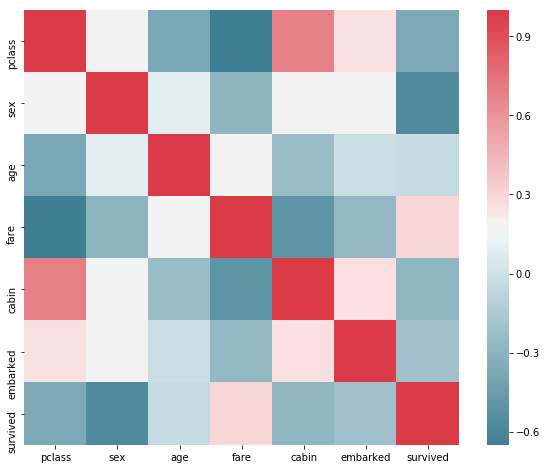

In [12]:
corr = train.corr()

f, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(corr, mask = np.zeros_like(corr, dtype = np.bool), cmap = sns.diverging_palette(220, 10, as_cmap = True),
            square = True, ax = ax)

In [13]:
# Alta correlação, 'cabin' pode ser removido
if 'cabin' in train:
    train.drop(['cabin'], axis = 1, inplace = True)

if 'cabin' in test:
    test.drop(['cabin'], axis = 1, inplace = True)
    
display(train[0:10])

,pclass,sex,age,fare,embarked,survived
0,1.0,1.0,0.334089,0.146482,1.0,0
1,0.0,1.0,0.659960,0.233522,1.0,0
2,0.5,1.0,0.404931,0.063688,1.0,0
3,1.0,1.0,0.277416,0.059720,1.0,0
4,1.0,0.0,0.050723,0.101294,1.0,1
5,0.0,0.0,0.560782,0.815811,0.0,1
6,0.5,1.0,0.433267,0.078852,1.0,1
7,1.0,0.0,0.376594,0.075667,1.0,1
8,1.0,0.0,0.291584,0.046401,1.0,1
9,1.0,0.0,0.546614,0.176658,0.5,0


##### Construindo conjuntos de treino e teste

In [14]:
x_train = train.filter(['pclass', 'sex', 'age', 'fare', 'embarked'], axis = 1)
y_train = train.filter(['survived'], axis = 1)

# x_test = test.filter(['pclass', 'sex', 'age', 'fare', 'embarked'], axis = 1)
# y_test = test.filter(['survived'], axis = 1)

x_train_list = x_train.values.tolist()

y_train_list = []
for i in y_train.values.tolist():
    if(i[0] >= 0.5):
        y_train_list.append([1.0, 0.0])
    else:
        y_train_list.append([0.0, 1.0])
        
# x_test_list = x_test.values.tolist()

# y_test_list = []
# for i in y_test.values.tolist():
#    if(i[0] >= 0.5):
#        y_test_list.append([1.0, 0.0])
#    else:
#        y_test_list.append([0.0, 1.0])
        
dataset = DataSet() 
for inst_x, inst_y in zip(x_train_list, y_train_list):
    dataset.add(Instance(inst_x, inst_y))
    
#for inst_x, inst_y in zip(x_test_list, y_test_list):
#    dataset.add(Instance(inst_x, inst_y))

##### Treinamento (Holdout)

In [24]:
net = NeuralNetwork(5, [30, 10, 2], [relu_func, relu_func, soft_max_func], dropout = [0.2, 0.5, 0.5])
data = net.fit(dataset, "mini-batch", 500, lr_ = 0.001, type = "class", mini_batch_size = 20, 
                      tvt_ratio = [9, 1, 1], print_info = False, opt = 'adam')

51/51 [==============================] - 0s 306us/step
[0.17974902631021014, 0.7254901960784313]


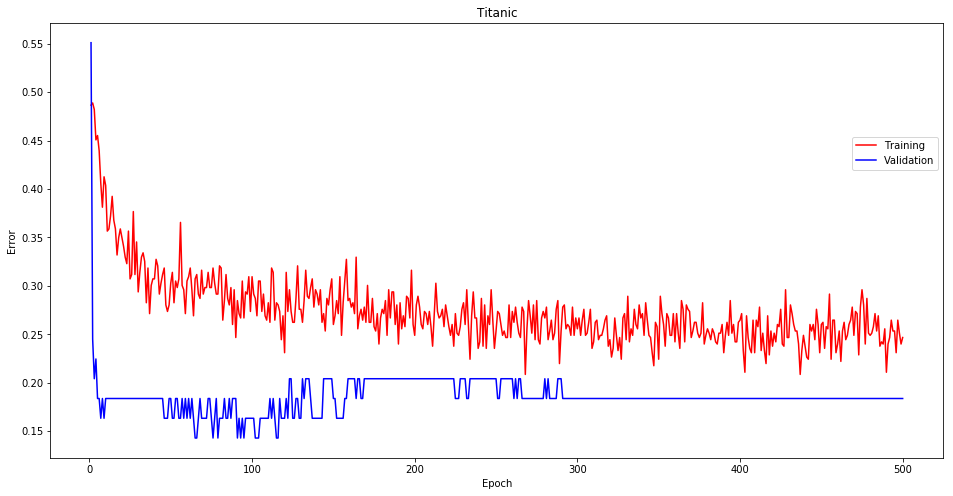

In [25]:
plot_graph(data, "Titanic", "Epoch", "Error", figsizex = 16, figsizey = 8)

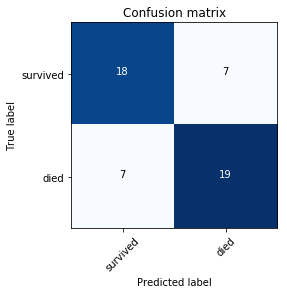

Test Accuracy:  72.54901960784314 %


In [26]:
correct = net.confusion_matrix[0][0] * [0] + \
          net.confusion_matrix[0][1] * [0] + \
          net.confusion_matrix[1][0] * [1] + \
          net.confusion_matrix[1][1] * [1]
            
predict = net.confusion_matrix[0][0] * [0] + \
          net.confusion_matrix[0][1] * [1] + \
          net.confusion_matrix[1][0] * [0] + \
          net.confusion_matrix[1][1] * [1]
            
mat = confusion_matrix(correct, predict)
plot_confusion_matrix(mat, classes = ['survived', 'died'], title = 'Confusion matrix')
plt.show()
print('Test Accuracy: ',
      (net.confusion_matrix[0][0] + 
       net.confusion_matrix[1][1]) / 
      (net.confusion_matrix[0][0] + 
       net.confusion_matrix[0][1] + 
       net.confusion_matrix[1][0] + 
       net.confusion_matrix[1][1]) * 100, '%')

##### Treinamento (Cross-validation)

In [21]:
n_split = 10
kfold = StratifiedKFold(n_splits = n_split, shuffle = True, random_state = 11403723)

idx = 1
data_cv_mean = [0, 0, 0]
matrix_mean = []
for a, b in kfold.split(x_train, y_train):
    
    print("\rTraining fold: ", idx)
    idx += 1
    dataset = None
    dataset = DataSet()
    
    for ind in a:
        dataset.add(Instance(x_train_list[ind], y_train_list[ind]))
    
    for ind in b:
        dataset.add(Instance(x_train_list[ind], y_train_list[ind]))
        
    #for ind in range(len(x_test_list)):
    #    dataset.add(Instance(x_test_list[ind], y_test_list[ind]))

    net_cv = NeuralNetwork(5, [30, 10, 2], [relu_func, relu_func, soft_max_func], dropout = [0.2, 0.5, 0.5])
    data_cv = net_cv.fit(dataset, "mini-batch", 500, lr_ = 0.001, type = "class", mini_batch_size = 20, 
                         tvt_ratio = [9, 1, 1], print_info = False, opt = 'adam')
    
    if data_cv_mean[0] == 0:
        data_cv_mean = data_cv.copy()
        matrix_mean = net_cv.confusion_matrix.copy()
    else:
        data_cv_mean[1] = [ i+j for i, j in zip(data_cv_mean[1], data_cv[1]) ]
        data_cv_mean[2] = [ i+j for i, j in zip(data_cv_mean[2], data_cv[2]) ]
        
        for i in range(len(matrix_mean)):
            for j in range(len(matrix_mean[i])):
                matrix_mean[i][j] += net_cv.confusion_matrix[i][j]
                

data_cv_mean[1] = [ elem/n_split for elem in data_cv_mean[1]]
data_cv_mean[2] = [ elem/n_split for elem in data_cv_mean[2]]
matrix_mean = [ [ kk//n_split for kk in k ] for k in matrix_mean ]

n = NeuralNetwork(1, [2], [sig_func])
n.confusion_matrix = matrix_mean

Training fold:  1
51/51 [==============================] - 0s 306us/step
[0.13056562402669122, 0.8235294117647058]
Training fold:  2
51/51 [==============================] - 0s 0us/step
[0.14578254937249072, 0.803921568627451]
Training fold:  3
51/51 [==============================] - 0s 306us/step
[0.11731410581691593, 0.8431372513958052]
Training fold:  4
51/51 [==============================] - 0s 306us/step
[0.14062699967739628, 0.8039215639525769]
Training fold:  5
51/51 [==============================] - 0s 0us/step
[0.14486741595992855, 0.82352941643958]
Training fold:  6
51/51 [==============================] - 0s 306us/step
[0.09594238293813724, 0.8627450886894675]
Training fold:  7
51/51 [==============================] - 0s 186us/step
[0.16422725308175182, 0.7450980333720937]
Training fold:  8
51/51 [==============================] - 0s 294us/step
[0.14374376687349058, 0.8235294269580468]
Training fold:  9
51/51 [==============================] - 0s 206us/step
[0.17865573278

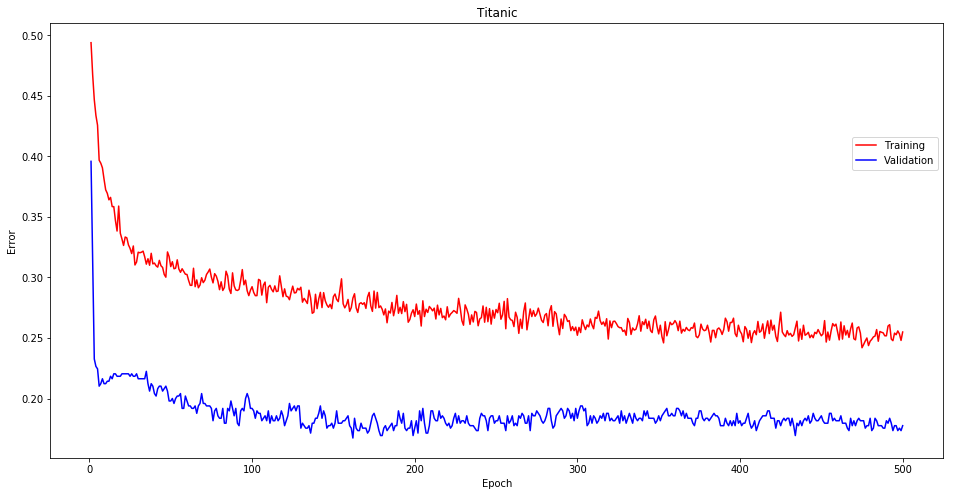

In [22]:
plot_graph(data_cv_mean, "Titanic", "Epoch", "Error", figsizex = 16, figsizey = 8)

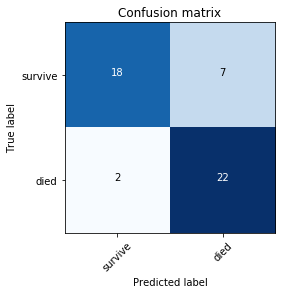

Test Accuracy:  80.3921568627451 %


In [23]:
correct = n.confusion_matrix[0][0] * [0] + \
          n.confusion_matrix[0][1] * [0] + \
          n.confusion_matrix[1][0] * [1] + \
          n.confusion_matrix[1][1] * [1]
            
predict = n.confusion_matrix[0][0] * [0] + \
          n.confusion_matrix[0][1] * [1] + \
          n.confusion_matrix[1][0] * [0] + \
          n.confusion_matrix[1][1] * [1]
            
mat = confusion_matrix(correct, predict)
plot_confusion_matrix(mat, classes = ['survive', 'died'], title = 'Confusion matrix')
plt.show()

print('Test Accuracy: ',
      (net.confusion_matrix[0][0] + 
       net.confusion_matrix[1][1]) / 
      (net.confusion_matrix[0][0] + 
       net.confusion_matrix[0][1] + 
       net.confusion_matrix[1][0] + 
       net.confusion_matrix[1][1]) * 100, '%')